In [1]:
# ! pip install python-dotenv

In [2]:
from dotenv import load_dotenv
import os 

load_dotenv()

# Loading Credentials
api_key = os.getenv("AZURE_OPENAI_API_KEY")
api_version = os.getenv("API_VERSION")
api_endpoint = os.getenv("AZURE_BASE_URL")
together_api = os.getenv("TOGETHER_API_KEY")

In [3]:
# ! pip install gdown

# !gdown 1yVbhJWh4L1unDbDT4APOusTXlwic7aE9

### Extracting Text and Images from the PDF

In [4]:
# ! pip install PyMuPDF

* here we can check how to pass the base64 encoded images to open ai model for usage
* note that the variable name for the image is still image_url, but we pass the image in base64 format

https://platform.openai.com/docs/guides/vision/uploading-base-64-encoded-images

In [5]:
import base64

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [6]:
# ! pip install openai

In [7]:
from openai import AzureOpenAI

client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    azure_endpoint=api_endpoint)


def describe_image(base64_image):
    """
    Uses OpenAI's GPT-4o model to generate a description of the image.
    """
    response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        { "role": "system", "content": "Your job is to extract all the information from the images, includng the text. Extract all the text from the image without changing the order or structure of the information. recheck if all the text has been extracted correctly and return in the same presentation and structure as present in the original image. "},
         { "role": "user",
          "content": [
            {"type": "text", "text": "extract ALL the text from the image in the same structure as present in the image. and then after it summarise everything in brief, do not miss anything "},
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/png;base64,{base64_image}",
              },
            },
          ],
        }
      ],
      max_tokens=300,
    )
    
    return response.choices[0].message.content

In [8]:

import fitz  # PyMuPDF wrapper for simplicity

def extract_images_and_text_from_pdf(pdf_path, output_folder):
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize a variable to store the combined text
    combined_text = ""

    # Loop through each page
    for page_number in range(len(pdf_document)):
        
        # Only testing till page number 10, main purpose is to build and end-to-end pipeline
        if page_number > 10:
            break

        page = pdf_document.load_page(page_number)

        # Loading text from pdf
        text = page.get_text()

        # Add the text of the current page to combined_text
        combined_text += f"\n\nPage {page_number + 1}:\n{text}"

        # Get the images from the page
        image_list = page.get_images(full=True)

        # Extract and process each image
        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            image_filename = f"page_{page_number+1}_img_{img_index+1}.{image_ext}"
            image_filepath = os.path.join(output_folder, image_filename)

            # Save the image to the output folder
            with open(image_filepath, "wb") as image_file:
                image_file.write(image_bytes)

            # Encode the image to base64
            base64_image = encode_image(image_filepath)

            # Use GPT-4o to describe the image and extract text
            image_description = describe_image(base64_image)

            # Add the image description and reference to combined_text
            combined_text += f"\n\n[Image: {image_filename}]\n{image_description}"

            print(f"Processed {image_filename} on page {page_number + 1}")

    print("Processing complete.")

    # Return the combined text
    return combined_text

# # Example usage
# pdf_path = "PA - Consolidated lecture notes.pdf"
# output_folder = "extracted_images_new"
# combined_text = extract_images_and_text_from_pdf(pdf_path, output_folder)

# # Optionally save the combined text to a file
# with open("combined_text.txt", "w") as text_file:
#     text_file.write(combined_text)

In [9]:
# ! pip install langchain-community

In [10]:
from langchain_community.document_loaders import TextLoader

loaders = TextLoader("combined_text.txt")

print(loaders.load()[0].page_content)



Page 1:
Product Sense -
How to tackle product strategy and business acumen rounds in
interviews?
Lecture Objective:
How to address business acumen questions round :
●
Analyzing a metric change. What’s a metric?
●
Defining metrics to measure performance / success of a new feature / product.
Importance of product strategy & business acumen rounds -
●
Apart from building models, developing dashboards and reporting frameworks -
One of the main responsibilities of a data scientist is to extract insights from
data and work with product managers and engineering teams to deliver
actionable plans to improve the product.
●
Product sense is about understanding all possibilities, not finding one correct
answer.
Example Questions: Product Acumen / Business Acumen
●
Why did Youtube’s traffic drop by 5%?
●
How would you measure the success of the “Save Post” feature on Facebook?
●
What metrics would you define to measure the health of the product search in
Amazon?
●
We have a dashboard tracking our

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 60,
    separators=["\n\n","\n"]
)

In [12]:
splits = text_splitter.split_documents(loaders.load())
len(splits)

47

In [14]:
# %pip install -qU langchain-openai

In [15]:
from langchain_openai import AzureOpenAIEmbeddings

In [18]:
embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=api_key,
    api_version=api_version,
    azure_endpoint=api_endpoint
)

In [23]:
!nvidia-smi

Thu Mar 20 00:01:13 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P8    16W /  N/A |     56MiB /  5946MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# ! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 4.3 MB/s eta 0:00:00a 0:00:01


In [26]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(splits, embeddings)
print(db.index.ntotal)

47


### LangChain GPT model initialization

In [29]:
from langchain.chains import RetrievalQA
from langchain.chat_models import AzureChatOpenAI


llm = AzureChatOpenAI(
    api_key=api_key, 
    model_name='gpt-4o-mini',
    api_version = api_version,
    azure_endpoint = api_endpoint,
    temperature=0)

In [30]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer and dont find it in the given context, just say that you don't know , don't try to make up an answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [31]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=db.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [33]:
result = qa_chain({"query": "what does CRIED refer to ?"})
print(result['result'])

CRIED refers to a framework for investigating an incident, specifically in the context of product diagnostics. It stands for:  
- C - Clarify  
- R - Rule Out  
- I - Internal  
- E - External  
- D - Data  


In [34]:
result["source_documents"][0]

Document(id='1e2c294c-e8a9-4f0f-9f97-9a1f70a12a0d', metadata={'source': 'combined_text.txt'}, page_content='**Summary:**\nThe image depicts a diagram titled "CRIED," which has two main branches stemming from it: "Clarify" and "Rule Out." Under "Rule Out," there is a further division into "Internal & External" and "Data." The structure represents a thought process or methodology.')

In [37]:
print(result["source_documents"][0].page_content)

**Summary:**
The image depicts a diagram titled "CRIED," which has two main branches stemming from it: "Clarify" and "Rule Out." Under "Rule Out," there is a further division into "Internal & External" and "Data." The structure represents a thought process or methodology.


In [43]:
# ! pip install opencv-python
# ! pip install matplotlib

In [44]:
import re
import os
import cv2
import matplotlib.pyplot as plt


# Function to extract image references from the text
def extract_image_references(text):
    pattern = r"\[Image:\s*(.*?)\]"
    image_references = re.findall(pattern, text)
    return image_references

# Function to display an image using Matplotlib
def display_image(image_path):
    # Check if the image file exists
    if os.path.exists(image_path):
        # Load and display the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"Image file {image_path} not found.")

# Example usage
image_references = extract_image_references(result["source_documents"][0].page_content)
print("Extracted image references:", image_references)

# Assume images are stored in "output/images"
image_folder = "extracted_images_new"

# Display each referenced image
for image_file in image_references:
    image_path = os.path.join(image_folder, image_file)
    print(f"Displaying {image_file}...")
    display_image(image_path)



Extracted image references: []


Product sense problems can be categorized into different types, primarily focusing on understanding and analyzing product performance and user behavior. The two main categories highlighted are:

1. **Product Diagnostics**: This involves analyzing changes in specific metrics to understand the reasons behind those changes. Examples include investigating why new user sign-ups increased or why the 'Add To Cart' conversion rate decreased. The goal is to identify the factors contributing to these metric changes.

2. **New Product / Feature**: This category focuses on measuring the performance and success of new products or features. It includes defining success metrics for features, such as assessing the health of product search on platforms like Amazon or evaluating the effectiveness of a "Save Post" feature on Facebook.

Overall, product sense is about exploring various possibilities and insights rather than seeking a single correct answer, and it plays a crucial role in guiding product de

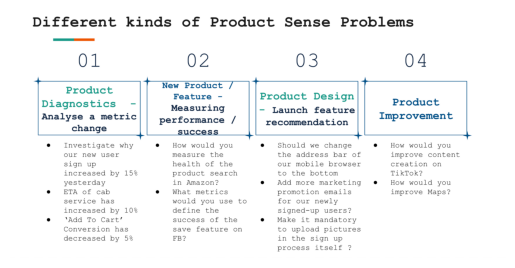

In [51]:
result = qa_chain({"query": "explain product sense probems"})
print(result['result'])

ret_text=""
for doc in result["source_documents"]:
  ret_text=ret_text+doc.page_content

image_references = extract_image_references(ret_text)
print("Extracted image references:", image_references)

for image_file in image_references:
    image_path = os.path.join(image_folder, image_file)
    print(f"Displaying {image_file}...")
    display_image(image_path)

In [52]:
result["source_documents"][0]

Document(id='9cd57dc2-85b5-4bcb-90db-07fc5571153a', metadata={'source': 'combined_text.txt'}, page_content='Page 5:\nDifferent Product Sense Problems -\n1. Product Diagnostics - Analyzing a metric change.\nCase - You notice that the percentage of users who clicked on a search result about a\nFacebook Event increased 15% week-over-week. How would you investigate this?\nGeneral Framework -\n\n\n[Image: page_5_img_1.png]\n### Extracted Text\n\n**Different kinds of Product Sense Problems**')

In [53]:
result["source_documents"][0].page_content

'Page 5:\nDifferent Product Sense Problems -\n1. Product Diagnostics - Analyzing a metric change.\nCase - You notice that the percentage of users who clicked on a search result about a\nFacebook Event increased 15% week-over-week. How would you investigate this?\nGeneral Framework -\n\n\n[Image: page_5_img_1.png]\n### Extracted Text\n\n**Different kinds of Product Sense Problems**'